## Tugas Besar II IF3270 Pembelajaran Mesin - RNN

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [14]:
import numpy as np
import pandas as pd
from customnn import RNN, Embedded, FullyConnected
from keras import layers
from keras import models

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [28]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vectorizer_val = vectorizer(df_valid['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()
y_val = df_valid['label'].to_numpy()

In [16]:
embedder = Embedded(vocabs, 100, embeddings_initializer='xavier')
embedded_vector = embedder.forward(vectorizer_data)

print(embedded_vector.shape)

(500, 100, 100)


In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])
y_valid_int = le.transform(df_valid['label'])

In [19]:
rnn_model = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.SimpleRNN(units=64, return_sequences=True),
    layers.SimpleRNN(units=128),
    layers.Dense(units=vocabs, activation='softmax')
])

rnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
rnn_model.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = rnn_model.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.0461 - loss: 7.8388 - val_accuracy: 0.2000 - val_loss: 7.0189
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2661 - loss: 6.6357 - val_accuracy: 0.2000 - val_loss: 5.2500
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2298 - loss: 4.8085 - val_accuracy: 0.2000 - val_loss: 3.3399
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2543 - loss: 2.9723 - val_accuracy: 0.2000 - val_loss: 1.9101
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2633 - loss: 1.7286 - val_accuracy: 0.4400 - val_loss: 1.3081
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3885 - loss: 1.2664 - val_accuracy: 0.4400 - val_loss: 1.1384
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3312 - loss: 1.1508 - val_accuracy: 0.3600 - val_loss: 1.1002
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3899 - loss: 1.1176 - val_accuracy: 0.3600 - val_loss: 1.0884


In [21]:
embedding_weights = rnn_model.layers[0].get_weights()[0]
rnn_weights = rnn_model.layers[1].get_weights()
kernel, recurrent_kernel, bias_rnn = rnn_weights
rnn_weights_2 = rnn_model.layers[2].get_weights()
kernel_2, recurrent_kernel_2, bias_rnn_2 = rnn_weights_2
dense_weights = rnn_model.layers[3].get_weights()
kernel_dense, bias_dense = dense_weights

In [24]:
from sklearn.metrics import f1_score

class RNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=True)
        self.rnn2 = RNN(unit=128, input_size=64, timestep=100, return_sequence=False)
        self.fc1 = FullyConnected(input_size=128, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.rnn2.forward(self.rnn1.forward(self.embedding.forward(x))))
    
rnn_from_scratch = RNNFromScratch(vocabs=vocabs)

rnn_from_scratch.embedding.weight = embedding_weights.copy()
rnn_from_scratch.rnn1.input_weights = kernel.copy()
rnn_from_scratch.rnn1.hidden_weights = recurrent_kernel.copy()
rnn_from_scratch.rnn1.bias = bias_rnn.copy()
rnn_from_scratch.rnn2.input_weights = kernel_2.copy()
rnn_from_scratch.rnn2.hidden_weights = recurrent_kernel_2.copy()
rnn_from_scratch.rnn2.bias = bias_rnn_2.copy()
rnn_from_scratch.fc1.weights = kernel_dense.copy()
rnn_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_data.numpy()

keras_output = rnn_model(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = rnn_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)

f1 = f1_score(keras_labels, scratch_labels, average='macro')

print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)


Difference: 1.315742673597517e-10
F1: 1.0


In [25]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.SimpleRNN(units=64, return_sequences=True)),
    layers.Bidirectional(layers.SimpleRNN(units=128)),
    layers.Dense(units=vocabs, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = bi_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.1518 - loss: 7.5209 - val_accuracy: 0.4400 - val_loss: 5.4400
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3683 - loss: 4.6523 - val_accuracy: 0.4400 - val_loss: 2.1028
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3629 - loss: 1.7373 - val_accuracy: 0.4400 - val_loss: 1.1223
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3598 - loss: 1.1262 - val_accuracy: 0.3600 - val_loss: 1.0690
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3732 - loss: 1.0934 - val_accuracy: 0.3600 - val_loss: 1.0688
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3690 - loss: 1.0884 - val_accuracy: 0.3600 - val_loss: 1.0777
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3800 - loss: 1.0869 - val_accuracy: 0.4400 - val_loss: 1.0582
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3564 - loss: 1.0893 - val_accuracy: 0.4400 - val_loss: 1.0549

In [26]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_rnn_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_rnn, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_rnn_reverse = bi_rnn_weights
bi_rnn_weights_2 = bi_models.layers[2].get_weights()
bi_kernel_2, bi_recurrent_kernel_2, bi_bias_rnn_2, bi_kernel_reverse_2, bi_recurrent_kernel_reverse_2, bi_bias_rnn_reverse_2 = bi_rnn_weights_2
bi_dense_weights = bi_models.layers[3].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [27]:
class BiRNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=True, bidirectional=True)
        self.rnn2 = RNN(unit=128, input_size=64, timestep=100, return_sequence=False, bidirectional=True)
        self.fc1 = FullyConnected(input_size=64, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.rnn2.forward(self.rnn1.forward(self.embedding.forward(x))))
    
bi_rnn_from_scratch = BiRNNFromScratch(vocabs=vocabs)

bi_rnn_from_scratch.embedding.weight = bi_embedding_weights.copy()
bi_rnn_from_scratch.rnn1.input_weights = bi_kernel.copy()
bi_rnn_from_scratch.rnn1.hidden_weights = bi_recurrent_kernel.copy()
bi_rnn_from_scratch.rnn1.bias = bi_bias_rnn.copy()
bi_rnn_from_scratch.rnn1.input_weights_reverse = bi_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.bias_reverse = bi_bias_rnn_reverse.copy()
bi_rnn_from_scratch.rnn2.input_weights = bi_kernel_2.copy()
bi_rnn_from_scratch.rnn2.hidden_weights = bi_recurrent_kernel_2.copy()
bi_rnn_from_scratch.rnn2.bias = bi_bias_rnn_2.copy()
bi_rnn_from_scratch.rnn2.input_weights_reverse = bi_kernel_reverse_2.copy()
bi_rnn_from_scratch.rnn2.hidden_weights_reverse = bi_recurrent_kernel_reverse_2.copy()
bi_rnn_from_scratch.rnn2.bias_reverse = bi_bias_rnn_reverse_2.copy()
bi_rnn_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_rnn_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_data.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_rnn_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')

print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)


Difference: 3.8399338558610013e-10
F1: 1.0


In [30]:
# RNN Models Hyperparameter Analysis
rnn_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128, return_sequences=True),
        layers.SimpleRNN(units=256),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=32),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.SimpleRNN(units=64)),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [31]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional"
]

1 Layer
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1634 - loss: 7.8064 - val_accuracy: 0.3600 - val_loss: 7.3093
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3669 - loss: 7.1137 - val_accuracy: 0.3600 - val_loss: 6.4029
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3924 - loss: 6.1563 - val_accuracy: 0.3600 - val_loss: 5.3736
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3867 - loss: 5.1123 - val_accuracy: 0.3600 - val_loss: 4.3124
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4005 - loss: 4.0596 - val_accuracy: 0.3600 - val_loss: 3.3112
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3813 - loss: 3.0981 - val_accuracy: 0.3600 - val_loss: 2.4627
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3904 - loss: 2.2994 - val_accuracy: 0.3600 - val_loss: 1.8557
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3935 - loss: 1.7546 - val_accuracy: 0.3600 - val_loss:

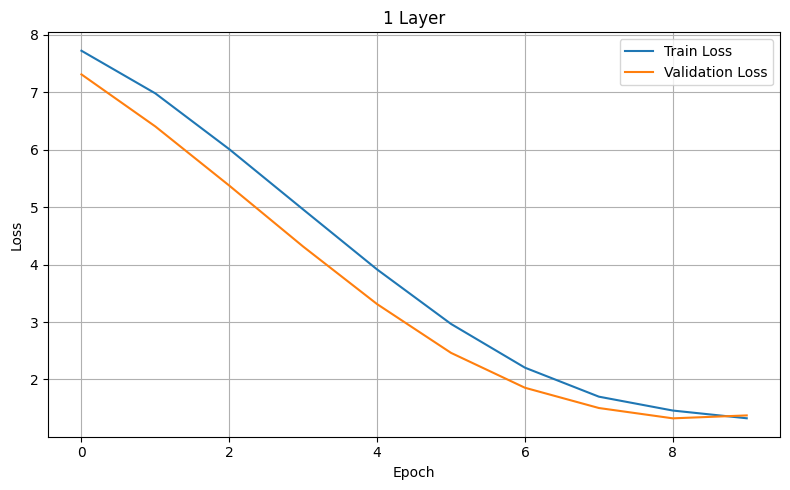


2 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.1338 - loss: 7.5711 - val_accuracy: 0.3600 - val_loss: 6.2753
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3694 - loss: 5.9067 - val_accuracy: 0.3600 - val_loss: 4.3952
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3795 - loss: 4.0465 - val_accuracy: 0.3600 - val_loss: 2.6615
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3903 - loss: 2.3983 - val_accuracy: 0.3600 - val_loss: 1.5894
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3721 - loss: 1.5736 - val_accuracy: 0.3600 - val_loss: 1.2213
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4124 - loss: 1.1959 - val_accuracy: 0.4400 - val_loss: 1.1103
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3615 - loss: 1.1450 - val_accuracy: 0.4400 - val_loss: 1.0969
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3707 - loss: 1.1454 - val_accuracy: 0.4400 - val_los

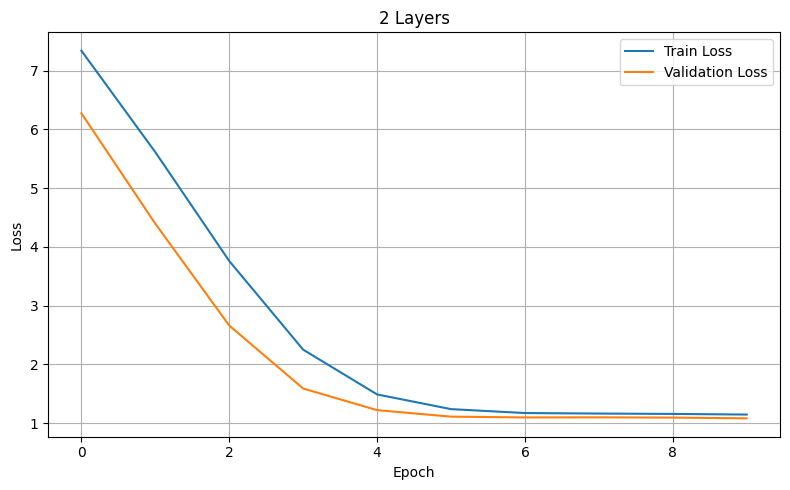


3 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.2280 - loss: 7.2587 - val_accuracy: 0.4400 - val_loss: 4.4798
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3774 - loss: 3.7676 - val_accuracy: 0.4400 - val_loss: 1.6767
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3901 - loss: 1.4790 - val_accuracy: 0.4400 - val_loss: 1.1023
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4178 - loss: 1.1212 - val_accuracy: 0.3600 - val_loss: 1.1136
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3930 - loss: 1.0977 - val_accuracy: 0.3600 - val_loss: 1.0671
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3494 - loss: 1.0877 - val_accuracy: 0.4400 - val_loss: 1.0560
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3586 - loss: 1.0920 - val_accuracy: 0.3600 - val_loss: 1.0654
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3919 - loss: 1.0820 - val_accuracy: 0.4400 - val_lo

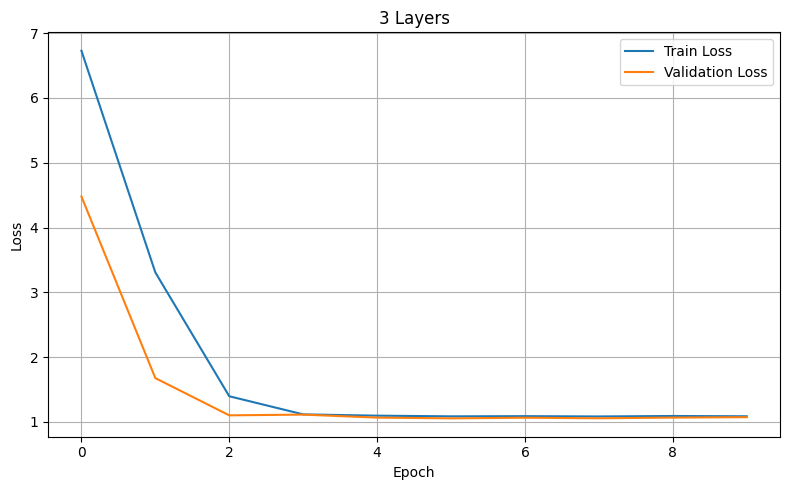


32 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.0000e+00 - loss: 7.9276 - val_accuracy: 0.3600 - val_loss: 7.7963
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4088 - loss: 7.7205 - val_accuracy: 0.3600 - val_loss: 7.4615
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3759 - loss: 7.3413 - val_accuracy: 0.3600 - val_loss: 6.9379
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4066 - loss: 6.7853 - val_accuracy: 0.3600 - val_loss: 6.3330
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3795 - loss: 6.1831 - val_accuracy: 0.3600 - val_loss: 5.7205
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3705 - loss: 5.5796 - val_accuracy: 0.3600 - val_loss: 5.1253
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3965 - loss: 4.9839 - val_accuracy: 0.3600 - val_loss: 4.5548
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3586 - loss: 4.4288 - val_accuracy: 0.3600 - val

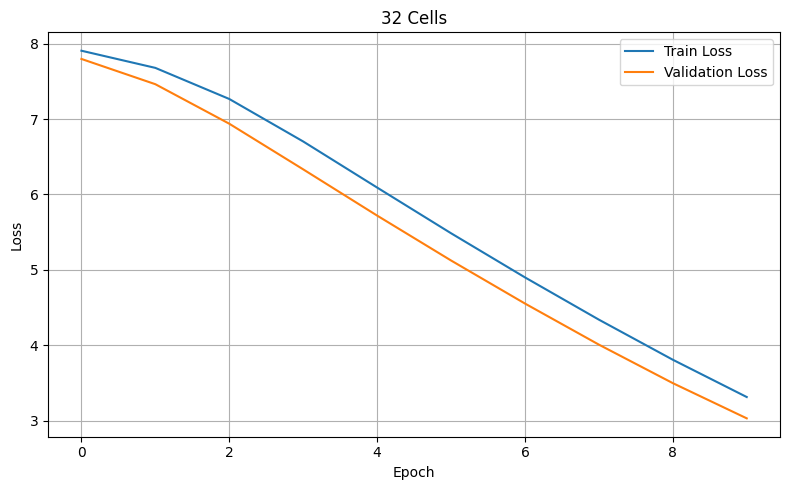


64 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0571 - loss: 7.8786 - val_accuracy: 0.4400 - val_loss: 7.4659
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3847 - loss: 7.3284 - val_accuracy: 0.3600 - val_loss: 6.6960
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4116 - loss: 6.4951 - val_accuracy: 0.3600 - val_loss: 5.6540
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3587 - loss: 5.4196 - val_accuracy: 0.4400 - val_loss: 4.4912
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3888 - loss: 4.2644 - val_accuracy: 0.4400 - val_loss: 3.3975
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3858 - loss: 3.2040 - val_accuracy: 0.4400 - val_loss: 2.4827
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3697 - loss: 2.3440 - val_accuracy: 0.4400 - val_loss: 1.8382
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3760 - loss: 1.7709 - val_accuracy: 0.4400 - val_los

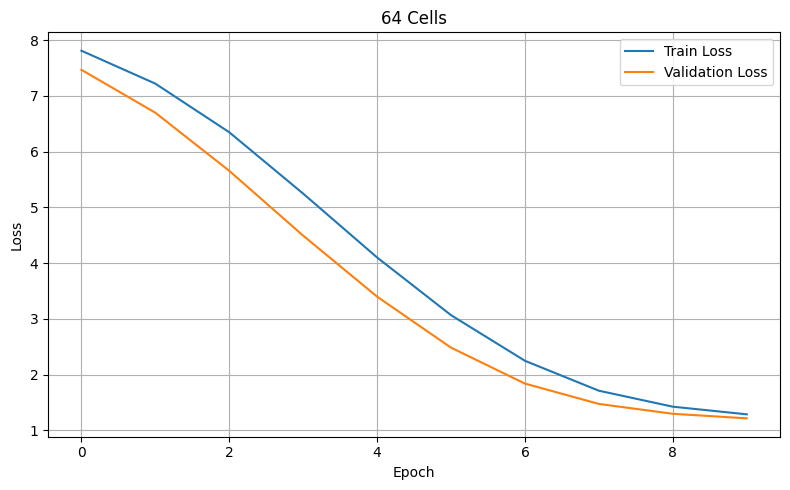


128 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.0635 - loss: 7.8622 - val_accuracy: 0.2000 - val_loss: 7.1494
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2511 - loss: 6.7913 - val_accuracy: 0.2000 - val_loss: 5.4427
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2546 - loss: 4.9573 - val_accuracy: 0.2000 - val_loss: 3.4199
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2499 - loss: 2.9965 - val_accuracy: 0.2000 - val_loss: 1.8802
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2313 - loss: 1.6934 - val_accuracy: 0.4400 - val_loss: 1.2813
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3711 - loss: 1.2411 - val_accuracy: 0.3600 - val_loss: 1.1244
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3924 - loss: 1.1368 - val_accuracy: 0.3600 - val_loss: 1.0921
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3612 - loss: 1.1125 - val_accuracy: 0.3600 - val_lo

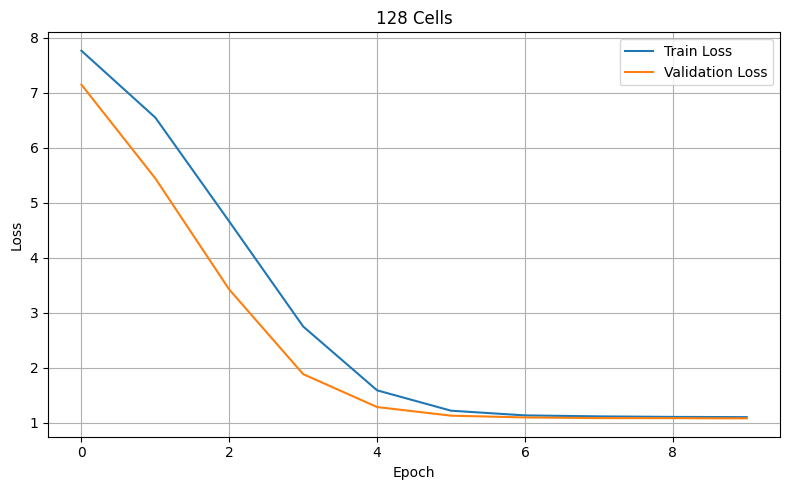


Unidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0000e+00 - loss: 7.9229 - val_accuracy: 0.3600 - val_loss: 7.6713
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2988 - loss: 7.5198 - val_accuracy: 0.2000 - val_loss: 6.9604
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2443 - loss: 6.7361 - val_accuracy: 0.2000 - val_loss: 5.9865
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2783 - loss: 5.7038 - val_accuracy: 0.3600 - val_loss: 4.8682
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3711 - loss: 4.5887 - val_accuracy: 0.3600 - val_loss: 3.7454
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3935 - loss: 3.4806 - val_accuracy: 0.3600 - val_loss: 2.7387
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3876 - loss: 2.5318 - val_accuracy: 0.3600 - val_loss: 1.9972
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3779 - loss: 1.8664 - val_accuracy: 0.3600

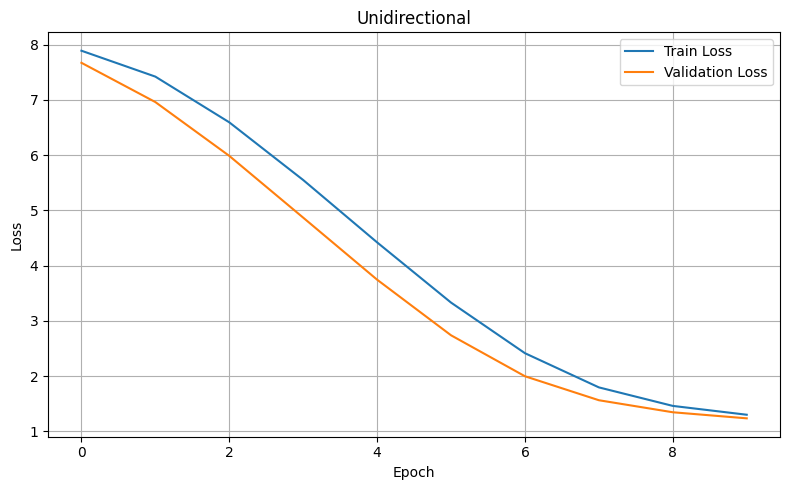


Bidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1018 - loss: 7.7728 - val_accuracy: 0.3600 - val_loss: 6.9882
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3598 - loss: 6.6587 - val_accuracy: 0.3600 - val_loss: 5.4122
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3672 - loss: 4.9772 - val_accuracy: 0.3600 - val_loss: 3.4508
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3831 - loss: 3.0280 - val_accuracy: 0.3600 - val_loss: 1.8116
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3778 - loss: 1.6312 - val_accuracy: 0.3600 - val_loss: 1.2333
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3832 - loss: 1.2027 - val_accuracy: 0.3600 - val_loss: 1.1177
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3858 - loss: 1.1201 - val_accuracy: 0.3600 - val_loss: 1.0904
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3603 - loss: 1.1091 - val_accuracy: 0.3600 - va

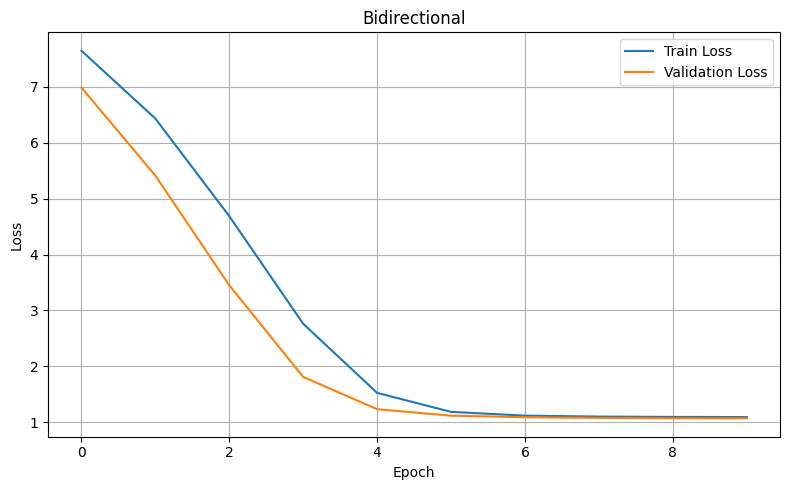

In [32]:
import matplotlib.pyplot as plt

n = 0

for model in rnn_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=10,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_val, y_valid_int)

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()

